# TensorFlow Tutorial 
# Modelo Linear Simples

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introdução

Este tutorial demonstra o fluxo de trabalho básico do uso do TensorFlow com um modelo linear simples. Depois de carregar o conjunto de dados chamado MNIST com imagens de dígitos escritos à mão, definimos e otimizamos um modelo matemático simples em TensorFlow. Os resultados são então plotados e discutidos.

Você deve estar familiarizado com álgebra linear básica, Python e o editor Jupyter Notebook. Também ajuda se você tiver uma compreensão básica de Machine Learning e classificação.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

Isso foi desenvolvido usando o Python 3.6.1 (Anaconda) e a versão do TensorFlow:

In [2]:
tf.__version__

'1.6.0'

## Load Data

O conjunto de dados MNIST é de cerca de 12 MB e será baixado automaticamente se não estiver localizado no caminho fornecido.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


O conjunto de dados MNIST foi agora carregado e consiste em 70.000 imagens e rótulos associados (isto é, classificações das imagens). O conjunto de dados é dividido em 3 subconjuntos mutuamente exclusivos. Nós usaremos somente os conjuntos de treinamento e teste neste tutorial.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot Encoding

O conjunto de dados foi carregado como a chamada codificação One-Hot. Isso significa que os rótulos foram convertidos de um único número para um vetor cuja extensão é igual ao número de classes possíveis. Todos os elementos do vetor são zero, exceto para o elemento $i$ que é um e significa que a classe é $i$. Por exemplo, as etiquetas codificadas do One-Hot para as primeiras 5 imagens no conjunto de teste são:

In [5]:
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Também precisamos das classes como números únicos para várias comparações e medidas de desempenho, por isso, convertemos os vetores codificados do One-Hot em um único número, pegando o índice do elemento mais alto. Observe que a palavra 'class' é uma palavra-chave usada em Python, portanto, precisamos usar o nome 'cls'.

In [0]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

Agora podemos ver a classe para as primeiras cinco imagens no conjunto de testes. Compare-os com os vetores codificados do One-Hot acima. Por exemplo, a classe da primeira imagem é 7, que corresponde a um vetor codificado em One-Hot, no qual todos os elementos são zero, exceto para o elemento com índice 7.

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions

As dimensões de dados são usadas em vários lugares no código-fonte abaixo. Na programação de computadores, geralmente é melhor usar variáveis e constantes do que ter que codificar números específicos toda vez que esse número for usado. Isso significa que os números só precisam ser alterados em um único lugar.

In [0]:
# Sabemos que as imagens MNIST são 28 pixels em cada dimensão.
img_size = 28

# Imagens são armazenadas em matrizes unidimensionais desse comprimento.
img_size_flat = img_size * img_size

# Tuple com altura e largura de imagens usadas para reformular matrizes.
img_shape = (img_size, img_size)

# Número de classes, uma classe para cada um dos 10 dígitos.
num_classes = 10

### Helper-function for plotting images

Função usada para plotar 9 imagens em uma grade de 3x3 e escrever as classes verdadeiras e previstas abaixo de cada imagem.

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Crie uma figura com sub-gráficos 3x3.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

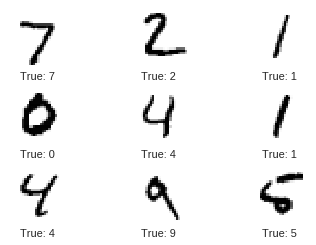

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

O propósito do TensorFlow é ter um  grafo computacional que pode ser executado com muito mais eficiência do que se os mesmos cálculos fossem executados diretamente no Python. O TensorFlow pode ser mais eficiente que o NumPy porque o TensorFlow conhece todo o grafo de computação que deve ser executado, enquanto o NumPy só conhece o cálculo de uma única operação matemática por vez.

O TensorFlow também pode grafocalcular automaticamente os gradientes necessários para otimizar as variáveis do grafo, a fim de melhorar o desempenho do modelo. Isso ocorre porque o grafo é uma combinação de expressões matemáticas simples, portanto, o gradiente do grafo inteiro pode ser calculado usando a regra de cadeia para derivadas.

O TensorFlow também pode aproveitar CPUs multi-core, bem comograph GPUs - e o Google até criou chips especiais apenas para o TensorFlow, que são chamados de TPUs (Tensor Processing Units) e são ainda mais rápidos que os GPUs.

Um grafo do TensorFlow consiste nas seguintes partes, que serão detalhadas abaixo:

* Variáveis de espaço reservado (Placeholder) variáveis usadas para alterar a entrada para o grafo.
* Variáveis do modelo   que serão otimizadas para melhorar o desempenho do modelo.
* O modelo que é essencialmente apenas uma função matemática que calcula alguma saída, dada a entrada nas variáveis de espaço reservado e as variáveis do modelo .
* Uma medida de custo que pode ser usada para guiar a otimização das variáveis.
* Um método de otimização que atualiza as variáveis do modelo.

Além disso, o grafo TensorFlow também pode conter várias declarações de depuração, por ex. para registrar os dados a serem exibidos usando o TensorBoard, que não é abordado neste tutorial.

### Placeholder variables

As variáveis de espaço reservado servem como entrada para o grafo que podemos alterar a cada vez que executamos o grafo. Chamamos isso de alimentar as variáveis de espaço reservado e isso é demonstrado mais adiante.

Primeiro, definimos a variável de espaço reservado para as imagens de entrada. Isso nos permite alterar as imagens que são inseridas no grafo do TensorFlow. Este é um chamado tensor, o que significa apenas que é um vetor ou matriz multidimensional. O tipo de dados é definido como `float32` e a forma é definida como` [None, img_size_flat] `, onde` None` significa que o tensor pode conter um número arbitrário de imagens, sendo cada imagem um vetor de comprimento `img_size_flat` .

In [0]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Em seguida, temos a variável de espaço reservado para os rótulos verdadeiros associados às imagens que foram inseridas na variável de espaço reservado x. A forma dessa variável de espaço reservado é `[None, num_classes]`, o que significa que ela pode conter um número arbitrário de rótulos e cada rótulo é um vetor de comprimento `num_classes`, que é 10 neste caso.

In [0]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Finalmente, temos a variável de espaço reservado para a verdadeira classe de cada imagem na variável de espaço reservado `x`. Estes são números inteiros e a dimensionalidade dessa variável de espaço reservado é definida como `[None]`, o que significa que a variável de espaço reservado é um vetor unidimensional de comprimento arbitrário.


In [0]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variáveis a serem otimizadas

Além das variáveis de espaço reservado que foram definidas acima e que servem como dados de entrada de alimentação no modelo, há também algumas variáveis de modelo que devem ser alteradas pelo TensorFlow para que o modelo tenha um melhor desempenho nos dados de treinamento.

A primeira variável que deve ser otimizada é chamada de `weights`(pesos) e é definida aqui como uma variável TensorFlow que deve ser inicializada com zeros e cuja forma é` [img_size_flat, num_classes] `, portanto, é um tensor bidimensional (ou matriz) com as linhas `img_size_flat` e` num_classes`.


In [0]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

A segunda variável que deve ser otimizada é chamada de `biases` e é definida como um tensor unidimensional (ou vetor) de comprimento 'num_classes'.

In [0]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

Este modelo matemático simples multiplica as imagens na variável de espaço reservado `x` com os `weights` e, em seguida, adiciona os `biases`.

O resultado é uma matriz de forma `[num_images, num_classes]` porque `x` tem forma` [num_images, img_size_flat] `e` weights` tem forma `[img_size_flat, num_classes]`, então a multiplicação dessas duas matrizes é uma matriz com forma `[num_images, num_classes]` e, em seguida, o vetor `biases` é adicionado a cada linha dessa matriz.

Note que o nome `logits` é uma terminologia típica do TensorFlow, mas outras pessoas podem chamar a variável de outra coisa.

In [0]:
logits = tf.matmul(x, weights) + biases

Agora, `logits` é uma matriz com as linhas ` num_images` e `num_classes`, onde o elemento $i$ linhas e $j$ é uma estimativa de quão provável  a imagem de entrada  $i$'  é da classe $j$ '.

No entanto, essas estimativas são um pouco ásperas e difíceis de interpretar porque os números podem ser muito pequenos ou grandes, então queremos normalizá-los para que cada linha da matriz `logits` 'seja somada a um, e cada elemento seja limitado entre zero e 1. Isso é calculado usando a chamada função softmax e o resultado é armazenado em `y_pred`.

In [0]:
y_pred = tf.nn.softmax(logits)

A classe prevista pode ser calculada a partir da matriz `y_pred` tomando o índice do maior elemento em cada linha.

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Função de custo a ser otimizado

Para tornar o modelo melhor na classificação das imagens de entrada, devemos de alguma forma alterar as variáveis para `weights` e` biases`. Para fazer isso, primeiro precisamos saber quão bem o modelo executa atualmente comparando a saída prevista do modelo `y_pred` com a saída desejada` y_true`.

A entropia cruzada é uma medida de desempenho usada na classificação. A entropia cruzada é uma função contínua que é sempre positiva e se a saída prevista do modelo corresponder exatamente à saída desejada, a entropia cruzada será igual a zero. O objetivo da otimização é, portanto, minimizar a entropia cruzada para que ela chegue o mais próximo possível de zero, alterando os `weights` e os `biases` do modelo.

TensorFlow tem uma função embutida para calcular a entropia cruzada. Note que ele usa os valores do `logits` porque também calcula o softmax internamente.

In [21]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Agora calculamos a entropia cruzada para cada uma das classificações de imagem, de forma que tenhamos uma medida de quão bem o modelo se comporta em cada imagem individualmente. Mas, para usar a entropia cruzada para guiar a otimização das variáveis do modelo, precisamos de um único valor escalar, de modo que simplesmente consideramos a média da entropia cruzada para todas as classificações de imagem.

In [0]:
cost = tf.reduce_mean(cross_entropy)

### Método de otimização

Agora que temos uma medida de custo que deve ser minimizada, podemos criar um otimizador. Neste caso, é a forma básica de Descida de Gradiente, em que o step-size é definido como 0,5.

Observe que a otimização não é executada neste momento. Na verdade, nada é calculado, apenas adicionamos o objeto otimizador ao grafo do TensorFlow para execução posterior.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Medidas de desempenho

Precisamos de mais algumas medidas de desempenho para exibir o progresso para o usuário.

Este é um vetor de booleanos se a classe prevista é igual à classe verdadeira de cada imagem.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Isso calcula a exatidão da classificação primeiro convertendo o vetor de booleanos em floats, de modo que False se torne 0 e True se torne 1, e então calcule a média desses números.

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Criar sessão do TensorFlow

Uma vez que o grafo do TensorFlow foi criado, temos que criar uma sessão do TensorFlow que é usada para executar o grafo.

In [0]:
session = tf.Session()

### Inicializar variáveis

As variáveis para `weights` e `biases` devem ser inicializadas antes de começarmos a otimizá-las.

In [0]:
session.run(tf.global_variables_initializer())

### Função auxiliar para executar iterações de otimização

Existem 50.000 imagens no conjunto de treinamento. Demora muito tempo para calcular o gradiente do modelo usando todas essas imagens. Portanto, usamos a Descida de Gradiente Estocástica, que usa apenas um pequeno lote de imagens em cada iteração do otimizador.

In [0]:
batch_size = 100

Função para executar várias iterações de otimização para melhorar gradualmente os `weights` e `biases` do modelo. Em cada iteração, um novo lote de dados é selecionado a partir do conjunto de treinamento e, em seguida, o TensorFlow executa o otimizador usando essas amostras de treinamento.

In [0]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Funções auxiliares para mostrar o desempenho

Dicionário com os dados do conjunto de teste a serem usados como entrada para o grafo do TensorFlow. Observe que devemos usar os nomes corretos para as variáveis de espaço reservado no grafo do TensorFlow.

In [0]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

Função para imprimir a precisão da classificação no conjunto de teste.

In [0]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Função para imprimir e plotar a matriz de confussion usando o scikit-learn.

In [0]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Função para plotar exemplos de imagens do conjunto de testes que foram classificadas incorretamente.

In [0]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Função auxiliar para plotar os pesos do modelo

Função para traçar os 'pesos' do modelo. 10 imagens são plotadas, uma para cada dígito que o modelo é treinado para reconhecer.

In [0]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Desempenho antes de qualquer otimização

A precisão no conjunto de testes é de 9,8%. Isso ocorre porque o modelo só foi inicializado e não otimizado, então sempre prevê que a imagem mostre um dígito zero, como demonstrado no gráfico abaixo, e verifica-se que 9,8% das imagens no conjunto de testes acontecem para ser zero dígitos.

In [35]:
print_accuracy()

Accuracy on test-set: 9.8%


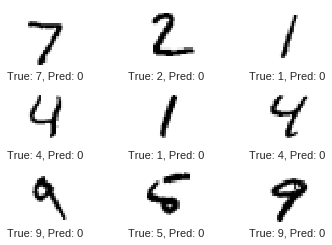

In [36]:
plot_example_errors()

## Desempenho após 1 iteração de otimização

Após uma única iteração de otimização, o modelo aumentou sua precisão no conjunto de testes para 40,7% de 9,8%. Isso significa que ele classifica erroneamente as imagens em 6 de 10 vezes, conforme demonstrado em alguns exemplos abaixo.

In [0]:
optimize(num_iterations=1)

In [71]:
print_accuracy()

Accuracy on test-set: 91.9%


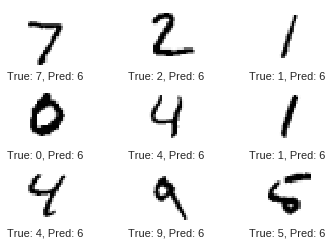

In [48]:
plot_example_errors()

Os pesos (weights) também podem ser plotados como mostrado abaixo. Pesos positivos são vermelhos e pesos negativos são azuis. Esses pesos podem ser intuitivamente entendidos como filtros de imagem.

Por exemplo, os pesos usados para determinar se uma imagem mostra um dígito zero têm uma reação positiva (vermelha) a uma imagem de um círculo e têm uma reação negativa (azul) a imagens com conteúdo no centro do círculo.

Da mesma forma, os pesos usados para determinar se uma imagem mostra um dígito reage positivamente (vermelho) a uma linha vertical no centro da imagem e reage negativamente (azul) a imagens com conteúdo em torno dessa linha.

Note que os pesos são parecidos com os dígitos que eles deveriam reconhecer. Isso ocorre porque apenas uma iteração de otimização foi executada, de forma que os pesos são treinados apenas em 100 imagens. Após o treinamento em vários milhares de imagens, os pesos tornam-se mais difíceis de interpretar porque eles precisam reconhecer muitas variações de como os dígitos podem ser escritos.

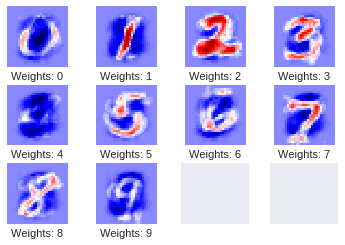

In [38]:
plot_weights()

## Desempenho após 10 iterações de otimização

In [0]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 76.6%


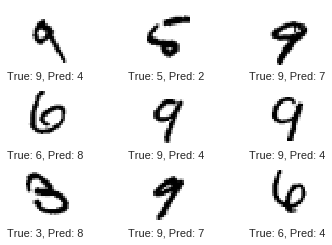

In [41]:
plot_example_errors()

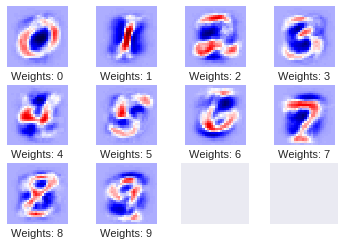

In [42]:
plot_weights()

## Desempenho após 1000 iterações de otimização

Após 1000 iterações de otimização, o modelo só classifica erroneamente cerca de uma em dez imagens. Como demonstrado abaixo, algumas das  falsas classificações são justificadas porque as imagens são muito difíceis de determinar com certeza, mesmo para os seres humanos, enquanto outras são bastante óbvias e deveriam ter sido classificadas corretamente por um bom modelo. Mas esse modelo simples não pode alcançar um desempenho muito melhor e, portanto, são necessários modelos mais complexos.

In [0]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [44]:
print_accuracy()

Accuracy on test-set: 91.7%


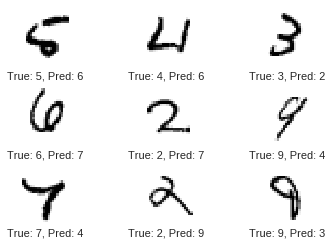

In [45]:
plot_example_errors()

O modelo foi treinado para 1000 iterações de otimização, com cada iteração usando 100 imagens do conjunto de treinamento. Devido à grande variedade de imagens, os pesos tornaram-se difíceis de interpretar e podemos duvidar se o modelo realmente entende como os dígitos são compostos de linhas, ou se o modelo acabou de memorizar muitas variações diferentes de pixels.

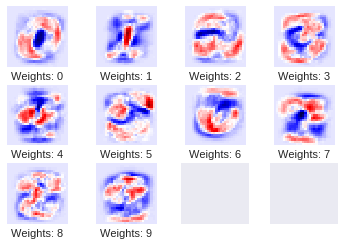

In [46]:
plot_weights()

Também podemos imprimir e traçar a chamada matriz de confusão, que nos permite ver mais detalhes sobre as falsas classificações. Por exemplo, isso mostra que as imagens que na verdade representam um 5 foram às vezes classificadas incorretamente como todos os outros dígitos possíveis, mas principalmente 3, 6 ou 8.

[[ 963    0    0    1    0    4    9    1    2    0]
 [   0 1109    2    2    0    1    4    2   15    0]
 [  11   13  883   15   10    3   14   17   56   10]
 [   4    1   12  885    0   43    3   17   36    9]
 [   1    3    2    1  902    0   13    3   12   45]
 [   9    4    3   23    8  777   15    7   39    7]
 [  14    3    3    1   10   15  902    3    7    0]
 [   3   13   18    7    5    1    0  948    3   30]
 [   4    6    3   15    7   19    9   10  896    5]
 [  11    9    2    7   27    7    0   25   13  908]]


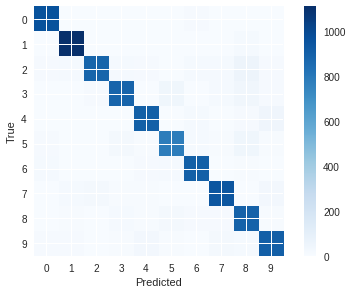

In [49]:
print_confusion_matrix()

Agora acabamos de usar o TensorFlow, então fechamos a sessão para liberar seus recursos.

In [0]:
# Isso foi comentado caso você queira modificar e experimentar com o Notebook sem ter que reiniciá-lo.
# session.close()

## Exercises

Estas são algumas sugestões de exercícios que podem ajudar a melhorar suas habilidades com o TensorFlow. É importante ter experiência prática com o TensorFlow para aprender a usá-lo corretamente.

Você pode querer fazer backup deste Notebook antes de fazer qualquer alteração.

* Altere a taxa de aprendizado do otimizador.
* Altere o otimizador para, e. `AdagradOptimizer` ou` AdamOptimizer`.
* Altere o tamanho do lote para, por exemplo, 1 ou 1000.
* Como essas mudanças afetam o desempenho? Você acha que essas mudanças terão o mesmo efeito (se houver) em outros problemas de classificação e modelos matemáticos?
* Você obtém os mesmos resultados se executar o Notebook várias vezes sem alterar nenhum parâmetro? Por que ou por que não?
* Mude a função `plot_example_errors ()` para que também imprima os valores `logits` e` y_pred` para os exemplos mal classificados.
* Use `sparse_softmax_cross_entropy_with_logits` em vez de` softmax_cross_entropy_with_logits`. Isso pode exigir várias alterações em vários locais no código-fonte. Discuta as vantagens e desvantagens de usar os dois métodos.
* Reformule o programa você mesmo sem olhar muito neste código-fonte.
* Explique a um amigo como o programa funciona.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.